In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error

In [2]:
df_boston = pd.read_csv("data/BostonHousing.csv")

In [3]:
df_boston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [4]:
df_boston.drop('b', axis=1, inplace=True)

In [5]:
df_boston.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     506 non-null    float64
 1   zn       506 non-null    float64
 2   indus    506 non-null    float64
 3   chas     506 non-null    int64  
 4   nox      506 non-null    float64
 5   rm       506 non-null    float64
 6   age      506 non-null    float64
 7   dis      506 non-null    float64
 8   rad      506 non-null    int64  
 9   tax      506 non-null    int64  
 10  ptratio  506 non-null    float64
 11  lstat    506 non-null    float64
 12  medv     506 non-null    float64
dtypes: float64(10), int64(3)
memory usage: 51.5 KB


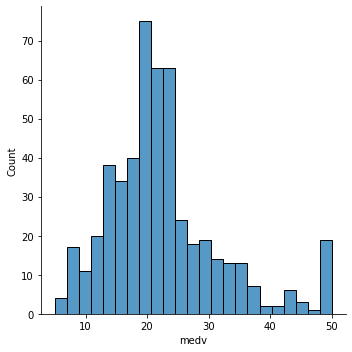

In [6]:
sns.displot(df_boston.medv)

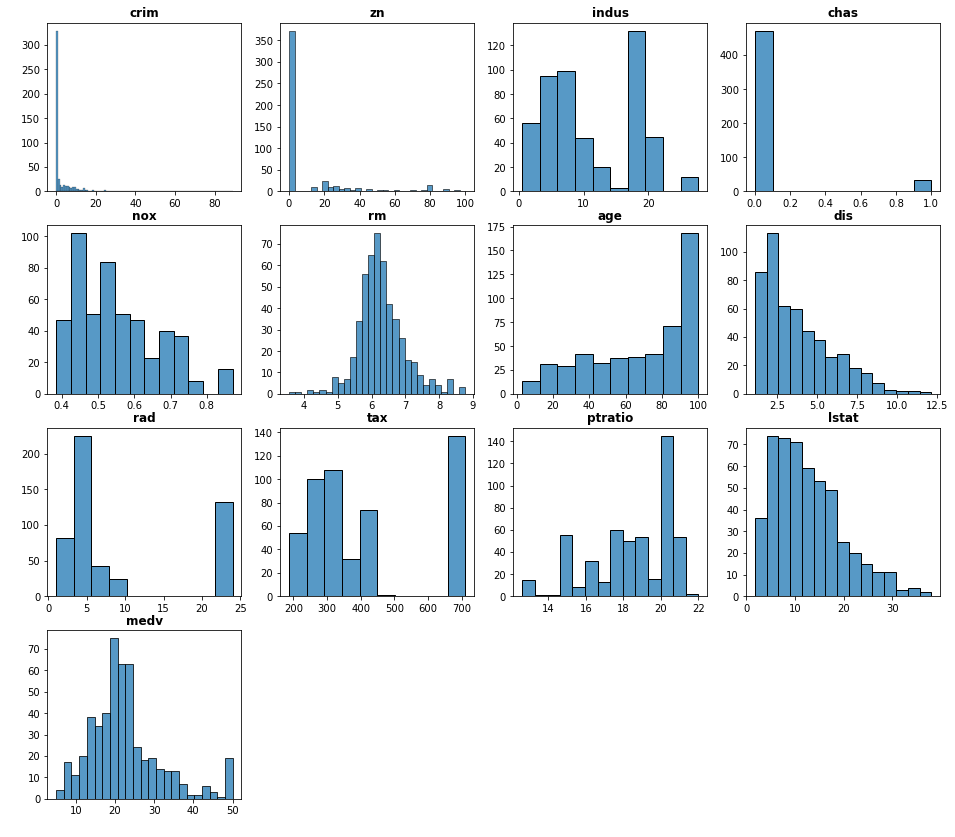

In [7]:
plt.figure(figsize= (16,18))
for i,col in enumerate(df_boston.columns):
    plt.subplot(5,4, i+1)
    sns.histplot(df_boston[col])
    plt.title(col, weight = 'bold')
    plt.ylabel(" ")
    plt.xlabel(" ")

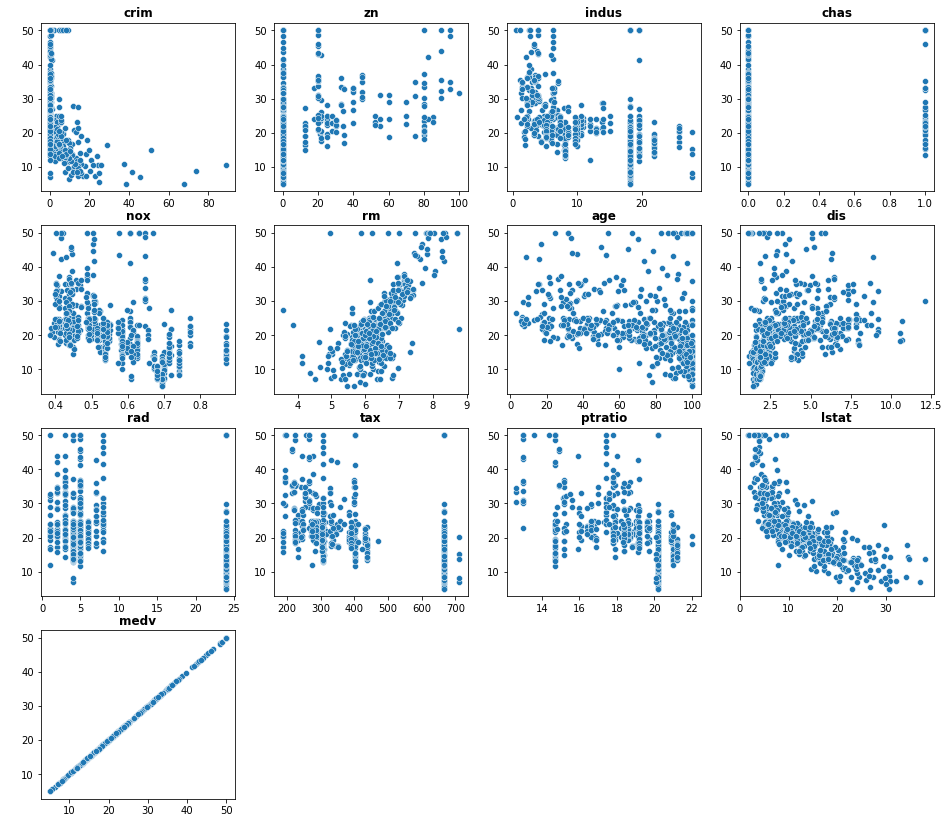

In [8]:
plt.figure(figsize= (16,18))
for i,col in enumerate(df_boston.columns):
    plt.subplot(5,4, i+1)
    sns.scatterplot(x=df_boston[col], y=df_boston.medv)
    plt.title(col, weight = 'bold')
    plt.ylabel(" ")
    plt.xlabel(" ")

## Data preprocessing

In [9]:
y = df_boston.medv
X = df_boston.drop('medv', axis=1)

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                    test_size=.20,
                                                    random_state=42)

## Create random forest

In [11]:
rf = RandomForestRegressor(n_estimators=70, 
                           random_state=42)

In [12]:
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=70, random_state=42)

In [13]:
feat_imp_sorted = rf.feature_importances_.argsort()

Text(0.5, 0, 'Feature importance Boston dataset')

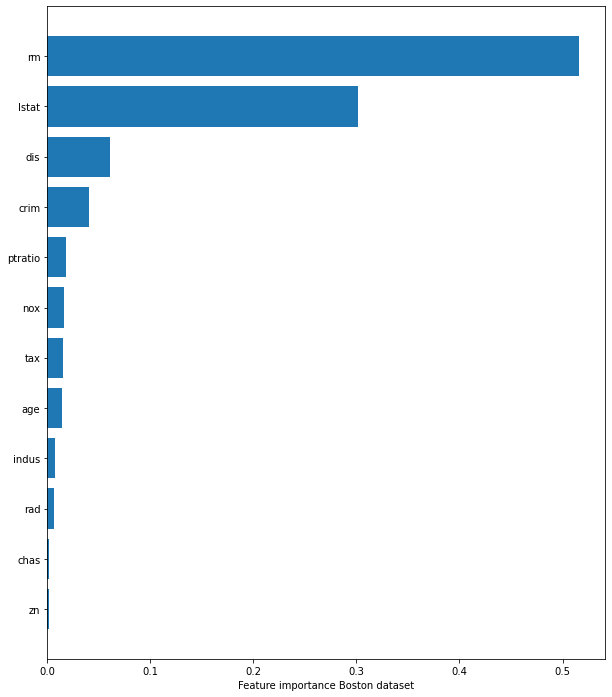

In [14]:
plt.figure(figsize=(10,12))

plt.barh(df_boston.columns[feat_imp_sorted], rf.feature_importances_[feat_imp_sorted])
plt.xlabel("Feature importance Boston dataset")

In [15]:
# Permutation importance using sklearn

r = permutation_importance(rf, X_val, y_val,
                            n_repeats=30,
                            random_state=0)

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{df_boston.columns[i]:<8}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

lstat   0.482 +/- 0.114
rm      0.479 +/- 0.068
dis     0.102 +/- 0.031
crim    0.040 +/- 0.006
nox     0.031 +/- 0.007
ptratio 0.027 +/- 0.007
age     0.013 +/- 0.005
tax     0.008 +/- 0.003


## Evauate the model

In [16]:
y_pred = rf.predict(X_val)

In [17]:
rmse = mean_squared_error(y_val, y_pred, squared=False)

In [18]:
print("RMSE: ", rmse)

RMSE:  2.7791724127372675


In average, the model is 2.95 off the target variable (medv).

In [19]:
df_boston.medv.describe()

count    506.000000
mean      22.532806
std        9.197104
min        5.000000
25%       17.025000
50%       21.200000
75%       25.000000
max       50.000000
Name: medv, dtype: float64

In [20]:
# Check to see if we're overfitting or underfitting

y_pred = rf.predict(X_train)

rmse = mean_squared_error(y_train, y_pred, squared=False)

print("RMSE: ", rmse)

RMSE:  1.4367138339751244


It looks like the random forest is overfitting the data. 

## Feature selection

In [21]:
rf_feat_imp_top_9 = df_boston.columns[feat_imp_sorted].tolist()[:10]
permutation_impt = [
    'lstat', 'rm',
    'dis', 'crim',
    'nox', 'ptratio',
    'age', 'tax',
]

In [22]:
y = df_boston.medv
#X = df_boston[feat_imp_top_9]
X = df_boston[permutation_impt]

In [23]:
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                    test_size=.20,
                                                    random_state=42)

In [24]:
rf = RandomForestRegressor(random_state=42)

In [25]:
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [26]:
y_pred = rf.predict(X_val)

rmse = mean_squared_error(y_val, y_pred, squared=False)

print("RMSE: ", rmse)

RMSE:  2.8409752847618126
